# Understanding Hired Rides in NYC

## Project Setup

### Installing Packages

In [1]:
# all import statements needed for the project, for example:
import folium 
from folium import plugins
import numpy as np
import math
from math import radians, cos, sin, asin, sqrt
import bs4
import matplotlib.pyplot as plt
import pandas as pd
import requests
import sqlalchemy as db
from sqlalchemy import text
import re
import geopandas as gpd
from os.path import exists
from IPython.core.display import display, HTML
!pip install pyarrow
!pip install fastparquet
!pip install folium 

In [2]:
# any general notebook setup, like log formatting

In [3]:
# any constants you might need, for example:

TAXI_URL = "https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page"
# add other constants to refer to any local data, e.g. uber & weather
UBER_CSV = "uber_rides_sample.csv"

NEW_YORK_BOX_COORDS = ((40.560445, -74.242330), (40.908524, -73.717047))

DATABASE_URL = "sqlite:///project.db"
DATABASE_SCHEMA_FILE = "schema.sql"
QUERY_DIRECTORY = "queries"

## Part 1: Data Preprocessing

### Calculating Distance


In [4]:
def calculate_distance(from_coord, to_coord):
    lat1=radians(from_coord[0])
    lat2=radians(to_coord[0])
    lon1=radians(from_coord[1])
    lon2=radians(to_coord[1])
    dis_lat=lat2-lat1
    dis_lon=lon2-lon1
    a = sin(dis_lat / 2)**2 + cos(lat1) * cos(lat2) * sin(dis_lon/ 2)**2
    c = 2 * asin(sqrt(a))
    return 6371*c

In [5]:
def add_distance_column(dataframe):
    distance_list = []
    for index, row in dataframe.iterrows():
        from_coord = []
        to_coord = []
        from_coord.append(row['pickup_latitude'])
        from_coord.append(row['pickup_longitude'])
        to_coord.append(row['dropoff_latitude'])
        to_coord.append(row['dropoff_longitude'])
        distance_list.append(calculate_distance(from_coord, to_coord))    
    dataframe['Distance'] = distance_list
    return dataframe

### Processing Taxi Data

**Getting Yellow Taxi URL**

In [6]:
def find_taxi_csv_urls():
    response = requests.get(TAXI_URL)
    former_result = response.content
    soup = bs4.BeautifulSoup(former_result, 'html.parser')
    
    result = []
    pattern = r"Yellow Taxi Trip Records"
    data = soup.find_all("a")
    for i in range(len(data)):
        matches = re.search(pattern, data[i].text)
        if type(matches) == re.Match:
            result.append(data[i]['href'])
    return result

**Define how to get shapefile to convert ID to coordinates**

In [7]:
def get_id_and_coordinate(shapefile):
    df = gpd.read_file(shapefile)
    df=df.to_crs(4326)
    #Find the center point
    df['Center_point'] = df['geometry'].centroid
    #Extract lat and lon from the centerpoint
    df["longitude"] = df.Center_point.map(lambda p: p.x)
    df["latitude"] = df.Center_point.map(lambda p: p.y)
    df = pd.concat([df["LocationID"], df["longitude"], df["latitude"]],axis = 1)
    return df

In [8]:
get_id_and_coordinate("taxi_zones.shp")
df_ID_coordinates_pickup = get_id_and_coordinate("taxi_zones.shp")
df_ID_coordinates_pickup.columns = ["PULocationID","pickup_longitude", "pickup_latitude"]

<ipython-input-7-ae9c73e78da5>:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df['Center_point'] = df['geometry'].centroid
<ipython-input-7-ae9c73e78da5>:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df['Center_point'] = df['geometry'].centroid


In [9]:
get_id_and_coordinate("taxi_zones.shp")
df_ID_coordinates_dropoff = get_id_and_coordinate("taxi_zones.shp")
df_ID_coordinates_dropoff.columns = ["DOLocationID","dropoff_longitude", "dropoff_latitude"]

<ipython-input-7-ae9c73e78da5>:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df['Center_point'] = df['geometry'].centroid
<ipython-input-7-ae9c73e78da5>:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df['Center_point'] = df['geometry'].centroid


**DownLoad Parquet**

In [10]:
def get_and_clean_month_taxi_data(url):
    #file_url = url
    pattern=r"[0-9]{4}-[0-9]{2}"
    match = re.search(pattern, url)
    fname=match.group()
    r = requests.get(url, stream = True)
    with open(f"python{fname}.parquet","wb") as parquet:
        for chunk in r.iter_content(chunk_size=100000):
            if chunk:
                parquet.write(chunk)

    name=f"python{fname}.parquet"
    df=pd.read_parquet(name,engine='auto')
    
    
   
    #df.columns = ["pickup_datetime", "dropoff_datetime", "trip_distance", "PULocationID", "DOLocationID", "tip_amount"]
    
    if "Trip_Pickup_DateTime" in df.columns: #For data in 2009
        df.rename(columns={"Trip_Pickup_DateTime": "pickup_datetime"}, inplace=True)
        df.rename(columns={"Trip_Dropoff_DateTime": "dropoff_datetime"}, inplace=True)
        df.rename(columns={"Trip_Distance": "trip_distance"}, inplace=True)
        df.rename(columns={"Start_Lon": "pickup_longitude"}, inplace=True)
        df.rename(columns={"Start_Lat": "pickup_latitude"}, inplace=True)
        df.rename(columns={"End_Lon": "dropoff_longitude"}, inplace=True)
        df.rename(columns={"End_Lat": "dropoff_latitude"}, inplace=True)
        df.rename(columns={"Tip_Amt": "tip_amount"}, inplace=True)
        
        df = pd.concat([
            df["pickup_datetime"], df["dropoff_datetime"], df["trip_distance"],
            df["pickup_longitude"],df["pickup_latitude"], 
            df["dropoff_longitude"],df["dropoff_latitude"],df["tip_amount"]],axis = 1)
    
    elif "pickup_datetime" in df.columns:  #For data in 2011
        df = pd.concat([
            df["pickup_datetime"], df["dropoff_datetime"], df["trip_distance"],
            df["pickup_longitude"],df["pickup_latitude"], 
            df["dropoff_longitude"],df["dropoff_latitude"],df["tip_amount"]],axis = 1)

    elif "tpep_pickup_datetime" in df.columns:  #For data from 2011 to 2022
        df.rename(columns={"tpep_pickup_datetime": "pickup_datetime"}, inplace=True)
        df.rename(columns={"tpep_dropoff_datetime": "dropoff_datetime"}, inplace=True)
        df = pd.concat([
            df["pickup_datetime"], df["dropoff_datetime"], df["trip_distance"], 
            df["PULocationID"], df["DOLocationID"],df["tip_amount"]],axis = 1)

        df = pd.merge(df, df_ID_coordinates_pickup, how = "left", on ="PULocationID")
        df = pd.merge(df, df_ID_coordinates_dropoff, how = "left", on ="DOLocationID")
        df.drop(["PULocationID","DOLocationID"],axis=1,inplace=True)
    
    return df


In [11]:
def get_and_clean_taxi_data():
    all_taxi_dataframes = []
    
    all_csv_urls = find_taxi_csv_urls()
    for csv_url in all_csv_urls:
        # maybe: first try to see if you've downloaded this exact file already and saved it before trying again

        # maybe: if the file hasn't been saved, save it so you can
        # avoid re-downloading it if you re-run the function
        pattern=r"[0-9]{4}-[0-9]{2}"
        match = re.search(pattern, csv_url)
        fname=match.group()
        
        if exists(f"Yellow_taxi{fname}.csv"):
            dataframe = pd.read_csv(f"Yellow_taxi{fname}.csv")
            
        else:
            dataframe = get_and_clean_month_taxi_data(csv_url)
            dataframe = dataframe.sample(n=2000, random_state=7) #generate samples that's roughly equal to Uber dataset
            
            add_distance_column(dataframe)
 
        for index, row in dataframe.iterrows():
            if row['pickup_latitude']<40.560445:
                dataframe = dataframe.drop(index)
            elif row['pickup_latitude']>40.908524:
                dataframe = dataframe.drop(index)
            elif row['dropoff_latitude']<40.560445:
                dataframe = dataframe.drop(index)
            elif row['dropoff_latitude']>40.908524:
                dataframe = dataframe.drop(index)
            elif row['pickup_longitude']<-74.242330:
                dataframe = dataframe.drop(index)
            elif row['pickup_longitude']>-73.717047:
                dataframe = dataframe.drop(index)
            elif row['dropoff_longitude']<-74.242330:
                dataframe = dataframe.drop(index) 
            elif row['dropoff_longitude']>-73.717047:
                dataframe = dataframe.drop(index)

        dataframe = dataframe.dropna(axis=0,how='any')

        dataframe.to_csv(f"Yellow_taxi{fname}.csv", index=False)
        #dataframe = pd.read_csv(f"Yellow_taxi{fname}.csv")

        all_taxi_dataframes.append(dataframe)
        
    # create one gigantic dataframe with data from every month needed
    taxi_data = pd.concat(all_taxi_dataframes)
    return taxi_data

### Processing Uber Data

**Download Uber Data and remove trips out of the box** 

In [12]:
def load_and_clean_uber_data(csv_file):
    df = pd.read_csv(csv_file,low_memory=False)
    df.drop(["key","fare_amount","passenger_count","Unnamed: 0"],axis=1,inplace=True)
    for index, row in df.iterrows():
        if row['pickup_latitude']<40.560445:
            df = df.drop(index)
        elif row['pickup_latitude']>40.908524:
            df = df.drop(index)
        elif row['dropoff_latitude']<40.560445:
            df = df.drop(index)
        elif row['dropoff_latitude']>40.908524:
            df = df.drop(index)
        elif row['pickup_longitude']<-74.242330:
            df = df.drop(index)
        elif row['pickup_longitude']>-73.717047:
            df = df.drop(index)
        elif row['dropoff_longitude']<-74.242330:
            df = df.drop(index) 
        elif row['dropoff_longitude']>-73.717047:
            df = df.drop(index)
    return df

In [13]:
def get_uber_data():
    uber_dataframe = load_and_clean_uber_data(UBER_CSV)
    add_distance_column(uber_dataframe)
    return uber_dataframe

### Processing Weather Data

**Get all the necessary columns in weather data**

**Fill in null values with 0 and mean**

In [14]:
def clean_month_weather_data_hourly(csv_file):
    original_df = pd.read_csv(csv_file ,low_memory=False)
    df = pd.concat([original_df["DATE"], original_df["HourlyPrecipitation"], original_df["HourlyWindSpeed"]],axis = 1)
    df["HourlyPrecipitation"] = df["HourlyPrecipitation"].replace('T', 0.00)
    df["HourlyPrecipitation"] = df["HourlyPrecipitation"].str.replace('s', '')
    df["HourlyPrecipitation"] = df["HourlyPrecipitation"].fillna(0.00)
    df["HourlyWindSpeed"] = df["HourlyWindSpeed"].fillna(0.00)
    df = df[df.DATE.str.contains(":51:00")]
    return df

In [15]:
def clean_month_weather_data_daily(csv_file):
    original_df = pd.read_csv(csv_file, low_memory=False)
    df = pd.concat([original_df["DATE"], original_df["DailyAverageWindSpeed"],original_df["Sunrise"],original_df["Sunset"]],axis = 1)
    df = df[df.DATE.str.contains("23:59:00")]
    df["DailyAverageWindSpeed"] = df["DailyAverageWindSpeed"].fillna(df["DailyAverageWindSpeed"].astype(float).mean())
    df["DailyAverageWindSpeed"] = df["DailyAverageWindSpeed"].fillna(0.00)
    df["Sunrise"] = df["Sunrise"].fillna(df["Sunrise"].astype(float).mean())
    df["Sunset"] = df["Sunset"].fillna(df["Sunset"].astype(float).mean())
    return df

In [16]:
def load_and_clean_weather_data():
    hourly_dataframes = []
    daily_dataframes = []
    
    weather_csv_files = ["2009_weather.csv", 
    "2010_weather.csv", "2011_weather.csv", 
    "2012_weather.csv","2013_weather.csv", 
    "2014_weather.csv", "2015_weather.csv",]
    
    for csv_file in weather_csv_files:
        hourly_dataframe = clean_month_weather_data_hourly(csv_file)
        daily_dataframe = clean_month_weather_data_daily(csv_file)
        hourly_dataframes.append(hourly_dataframe)
        daily_dataframes.append(daily_dataframe)
        
    # create two dataframes with hourly & daily data from every month
    hourly_data = pd.concat(hourly_dataframes)
    daily_data = pd.concat(daily_dataframes)
    
    return hourly_data, daily_data

### Process All Data


_**Run all the functions above**_

In [17]:

uber_data = get_uber_data()
hourly_weather_data, daily_weather_data = load_and_clean_weather_data()
taxi_data = get_and_clean_taxi_data()

In [18]:
hourly_weather_data

,DATE,HourlyPrecipitation,HourlyWindSpeed
0,2009-01-01T00:51:00,0.0,18.0
1,2009-01-01T01:51:00,0.0,18.0
2,2009-01-01T02:51:00,0.0,18.0
3,2009-01-01T03:51:00,0.0,8.0
4,2009-01-01T04:51:00,0.0,11.0
...,...,...,...
11380,2015-12-31T19:51:00,0.00,6.0
11381,2015-12-31T20:51:00,0.00,10.0
11382,2015-12-31T21:51:00,0.00,0.0
11383,2015-12-31T22:51:00,0.00,7.0


In [19]:
daily_weather_data

,DATE,DailyAverageWindSpeed,Sunrise,Sunset
55,2009-01-02T23:59:00,0.000000,720.000000,1640.00000
163,2009-01-06T23:59:00,0.000000,720.000000,1644.00000
202,2009-01-07T23:59:00,0.000000,720.000000,1645.00000
305,2009-01-10T23:59:00,0.000000,720.000000,1648.00000
343,2009-01-11T23:59:00,0.000000,720.000000,1649.00000
...,...,...,...,...
11264,2015-12-28T23:59:00,8.300000,719.000000,1636.00000
11312,2015-12-29T23:59:00,7.000000,720.000000,1636.00000
11351,2015-12-30T23:59:00,4.100000,720.000000,1637.00000
11385,2015-12-31T23:59:00,5.400000,720.000000,1638.00000


In [20]:
taxi_data

,pickup_datetime,dropoff_datetime,trip_distance,tip_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,Distance
0,2022-01-26 13:48:50,2022-01-26 13:51:33,0.57,1.00,-73.996971,40.742279,-73.996971,40.742279,0.000000
1,2022-01-13 23:53:57,2022-01-14 00:13:07,4.16,4.06,-73.965635,40.768615,-74.008984,40.735035,5.222630
2,2022-01-12 18:57:26,2022-01-12 19:08:02,1.18,1.92,-73.988787,40.753513,-73.996971,40.742279,1.426829
3,2022-01-04 07:44:15,2022-01-04 07:51:56,0.66,1.46,-73.968168,40.797962,-73.961764,40.809457,1.387213
4,2022-01-10 18:54:22,2022-01-10 19:06:22,3.00,1.00,-73.965146,40.756729,-74.001538,40.723888,4.768173
...,...,...,...,...,...,...,...,...,...
1959,2009-12-29 18:52:00,2009-12-29 19:00:00,1.82,0.00,-73.994457,40.755750,-74.002377,40.734517,2.453466
1960,2009-12-17 16:09:32,2009-12-17 16:33:40,6.10,0.00,-74.010487,40.718503,-73.982984,40.782506,7.484408
1961,2009-12-17 20:25:00,2009-12-17 20:30:00,0.88,0.00,-73.999313,40.730922,-73.987767,40.724363,1.215942
1962,2009-12-23 15:16:00,2009-12-23 15:21:00,1.19,0.00,-73.969417,40.756277,-73.957653,40.765547,1.429754


In [21]:
uber_data

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,Distance
0,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1.683323
1,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,2.457590
2,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,5.036377
3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,1.661683
4,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,4.475450
...,...,...,...,...,...,...
199995,2012-10-28 10:49:00 UTC,-73.987042,40.739367,-73.986525,40.740297,0.112210
199996,2014-03-14 01:09:00 UTC,-73.984722,40.736837,-74.006672,40.739620,1.875050
199997,2009-06-29 00:42:00 UTC,-73.986017,40.756487,-73.858957,40.692588,12.850319
199998,2015-05-20 14:56:25 UTC,-73.997124,40.725452,-73.983215,40.695415,3.539715


## Part 2: Storing Cleaned Data

### Creating Tables

In [22]:
engine = db.create_engine(DATABASE_URL,echo = True)
connection = engine.connect()

In [23]:
# Create 5 tables
HOURLY_WEATHER_SCHEMA = """
CREATE TABLE IF NOT EXISTS hourly_weather
(
    id INTEGER PRIMARY KEY,
    Date DATETIME,
    HourlyPrecipitation FLOAT,
    HourlyWindSpeed FLOAT
);
"""

DAILY_WEATHER_SCHEMA = """
CREATE TABLE IF NOT EXISTS daily_weather
(
    id INTEGER PRIMARY KEY,
    Date DATETIME,
    DailyAverageWindSpeed FLOAT,
    Sunrise FLOAT,
    Sunset FLOAT
);
"""


DAILY_SUNRISESUNSET_SCHEMA = """
CREATE TABLE IF NOT EXISTS daily_sunrisesunset
(
    id INTEGER PRIMARY KEY,
    Date DATETIME,
    Sunrise FLOAT,
    Sunset FLOAT
);
"""


TAXI_TRIPS_SCHEMA = """
CREATE TABLE IF NOT EXISTS taxi_trips
(
    id INTEGER PRIMARY KEY,
    pickup_datetime DATETIME,
    dropoff_datetime DATETIME,	
    trip_distance FLOAT,	
    tip_amount FLOAT,	
    pickup_longitude FLOAT,	
    pickup_latitude FLOAT,	
    dropoff_longitude FLOAT,	
    dropoff_latitude FLOAT,	
    Distance FLOAT
);

"""

UBER_TRIPS_SCHEMA = """
CREATE TABLE IF NOT EXISTS uber_trips
(
    id INTEGER PRIMARY KEY,
    pickup_datetime  DATETIME,
    pickup_longitude FLOAT,
    pickup_latitude FLOAT,
    dropoff_longitude FLOAT,
    dropoff_latitude FLOAT,
    Distance FLOAT
);
"""

In [24]:
# create that required schema.sql file
with open(DATABASE_SCHEMA_FILE, "w") as f:
    f.write(HOURLY_WEATHER_SCHEMA)
    f.write(DAILY_WEATHER_SCHEMA)
    f.write(TAXI_TRIPS_SCHEMA)
    f.write(UBER_TRIPS_SCHEMA)
    f.write(DAILY_SUNRISESUNSET_SCHEMA)

In [25]:
# create the tables with the schema files
with engine.connect() as connection:
    pass

### Add Data to Database

**Use pandas.to_sql to write data to the database**

In [26]:
def write_dataframes_to_table(table_to_df_dict):
    for keys, values in table_to_df_dict.items():
        values.to_sql(keys, con=engine,if_exists='replace', index=False)
        

In [27]:
daily_sunsrisesunset_data = pd.concat([
    daily_weather_data["DATE"], daily_weather_data["Sunrise"], daily_weather_data["Sunset"]],axis = 1)

In [28]:
map_table_name_to_dataframe = {
    "taxi_trips": taxi_data,
    "uber_trips": uber_data,
    "hourly_weather": hourly_weather_data,
    "daily_weather": daily_weather_data,
    "daily_sunrisesunset": daily_sunsrisesunset_data,
}

In [29]:
connection = engine.connect()
write_dataframes_to_table(map_table_name_to_dataframe)  #sometimes went wrong with if_exists="replace" 

2022-12-10 15:26:12,677 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2022-12-10 15:26:12,677 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("taxi_trips")
2022-12-10 15:26:12,678 INFO sqlalchemy.engine.Engine [raw sql] ()
2022-12-10 15:26:12,679 INFO sqlalchemy.engine.Engine ROLLBACK
2022-12-10 15:26:12,679 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2022-12-10 15:26:12,680 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("taxi_trips")
2022-12-10 15:26:12,680 INFO sqlalchemy.engine.Engine [raw sql] ()
2022-12-10 15:26:12,681 INFO sqlalchemy.engine.Engine ROLLBACK
2022-12-10 15:26:12,682 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2022-12-10 15:26:12,682 INFO sqlalchemy.engine.Engine SELECT name FROM sqlite_master WHERE type='table' AND name NOT LIKE 'sqlite~_%' ESCAPE '~' ORDER BY name
2022-12-10 15:26:12,683 INFO sqlalchemy.engine.Engine [raw sql] ()
2022-12-10 15:26:12,684 INFO sqlalchemy.engine.Engine SELECT name FROM sqlite_temp_master WHERE type='table' AND name N

In [30]:
!sqlite3 project.db < schema.sql

## Part 3: Understanding the Data

### Write Query to File

In [31]:
def write_query_to_file(query, outfile):
    with open (outfile,"w") as file:
        file.write(query)


In [32]:
engine = db.create_engine(DATABASE_URL,echo = True)
connection = engine.connect()


### Query 1

In [33]:
QUERY_Q1 = '''
SELECT strftime ('%H',pickup_datetime) AS Hour_Taxi,
COUNT(strftime ('%H',pickup_datetime))
FROM taxi_trips
WHERE pickup_datetime >= '2009-01-01 00:00:00'
AND pickup_datetime <= '2015-06-30 23:59:59'
GROUP BY Hour_Taxi
'''
connection.execute(text(QUERY_Q1)).fetchall()

2022-12-10 15:26:17,520 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2022-12-10 15:26:17,521 INFO sqlalchemy.engine.Engine 
SELECT strftime ('%H',pickup_datetime) AS Hour_Taxi,
COUNT(strftime ('%H',pickup_datetime))
FROM taxi_trips
WHERE pickup_datetime >= '2009-01-01 00:00:00'
AND pickup_datetime <= '2015-06-30 23:59:59'
GROUP BY Hour_Taxi

2022-12-10 15:26:17,521 INFO sqlalchemy.engine.Engine [generated in 0.00110s] ()


[('00', 6059),
 ('01', 4544),
 ('02', 3322),
 ('03', 2446),
 ('04', 1754),
 ('05', 1487),
 ('06', 3178),
 ('07', 5523),
 ('08', 6777),
 ('09', 7077),
 ('10', 6889),
 ('11', 7022),
 ('12', 7505),
 ('13', 7500),
 ('14', 7492),
 ('15', 7260),
 ('16', 6213),
 ('17', 7729),
 ('18', 9070),
 ('19', 9542),
 ('20', 9019),
 ('21', 8781),
 ('22', 8547),
 ('23', 7540)]

In [34]:
write_query_to_file(QUERY_Q1, "QUERY_Q1_most_popular_Yellow_Taxi.sql")

### Query 2

In [35]:
QUERY_Q2 ='''
SELECT strftime ('%w',substr(pickup_datetime, 1, 19)) AS WeekDay,
COUNT(strftime ('%w',substr(pickup_datetime, 1, 19)))
FROM uber_trips
WHERE pickup_datetime >= '2009-01-01 00:00:00'
AND pickup_datetime <= '2015-06-30 23:59:59'
GROUP BY WeekDay
ORDER BY COUNT(strftime ('%w',substr(pickup_datetime, 1, 19)))
'''
connection.execute(text(QUERY_Q2)).fetchall()

2022-12-10 15:26:17,795 INFO sqlalchemy.engine.Engine 
SELECT strftime ('%w',substr(pickup_datetime, 1, 19)) AS WeekDay,
COUNT(strftime ('%w',substr(pickup_datetime, 1, 19)))
FROM uber_trips
WHERE pickup_datetime >= '2009-01-01 00:00:00'
AND pickup_datetime <= '2015-06-30 23:59:59'
GROUP BY WeekDay
ORDER BY COUNT(strftime ('%w',substr(pickup_datetime, 1, 19)))

2022-12-10 15:26:17,795 INFO sqlalchemy.engine.Engine [generated in 0.00070s] ()


[('1', 24681),
 ('0', 25834),
 ('2', 27527),
 ('3', 28328),
 ('4', 29338),
 ('6', 29599),
 ('5', 30166)]

In [36]:
write_query_to_file(QUERY_Q2, "QUERY_Q2_most_popular_Wday_uber.sql")

### Query 3

In [37]:
QUERY_Q3 ='''
SELECT Distance
FROM (
    SELECT Distance
    FROM uber_trips
    WHERE pickup_datetime >= '2013-07-01 00:00:00'
    AND pickup_datetime <= '2013-07-31 23:59:59'
    AND Distance != 'None'
    AND Distance != 0
    UNION ALL
    SELECT Distance
    FROM taxi_trips
    WHERE pickup_datetime >= '2013-07-01 00:00:00'
    AND pickup_datetime <= '2013-07-31 23:59:59'
    AND Distance != 'None'
    AND Distance != 0
    )
    ORDER BY Distance
    LIMIT 1
    OFFSET(
        SELECT COUNT(*)
        FROM uber_trips
        WHERE pickup_datetime >= '2013-07-01 00:00:00'
        AND pickup_datetime <= '2013-07-31 23:59:59'
        AND Distance != 'None'
        AND Distance != 0
        UNION ALL
        SELECT Distance
        FROM taxi_trips
        WHERE pickup_datetime >= '2013-07-01 00:00:00'
        AND pickup_datetime <= '2013-07-31 23:59:59'
        AND Distance != 'None'
        AND Distance != 0
        )*95/100-1
        '''
connection.execute(text(QUERY_Q3)).fetchall()

2022-12-10 15:26:18,109 INFO sqlalchemy.engine.Engine 
SELECT Distance
FROM (
    SELECT Distance
    FROM uber_trips
    WHERE pickup_datetime >= '2013-07-01 00:00:00'
    AND pickup_datetime <= '2013-07-31 23:59:59'
    AND Distance != 'None'
    AND Distance != 0
    UNION ALL
    SELECT Distance
    FROM taxi_trips
    WHERE pickup_datetime >= '2013-07-01 00:00:00'
    AND pickup_datetime <= '2013-07-31 23:59:59'
    AND Distance != 'None'
    AND Distance != 0
    )
    ORDER BY Distance
    LIMIT 1
    OFFSET(
        SELECT COUNT(*)
        FROM uber_trips
        WHERE pickup_datetime >= '2013-07-01 00:00:00'
        AND pickup_datetime <= '2013-07-31 23:59:59'
        AND Distance != 'None'
        AND Distance != 0
        UNION ALL
        SELECT Distance
        FROM taxi_trips
        WHERE pickup_datetime >= '2013-07-01 00:00:00'
        AND pickup_datetime <= '2013-07-31 23:59:59'
        AND Distance != 'None'
        AND Distance != 0
        )*95/100-1
        
2022-1

[(2.5432487944601734,)]

In [38]:
write_query_to_file(QUERY_Q3, "QUERY_Q3_95percent_distance_all_hired_trips.sql")

### Query 4

In [39]:
QUERY_Q4='''
SELECT strftime('%Y-%m-%d',datetime(substr(pickup_datetime, 1, 19))) AS DAY,
COUNT(strftime('%Y-%m-%d',datetime(substr(pickup_datetime, 1, 19)))),
avg(Distance)
FROM (
    SELECT pickup_datetime, Distance
    FROM uber_trips
    WHERE pickup_datetime >= '2009-01-01 00:00:00'
    AND pickup_datetime <= '2009-12-31 23:59:59'
    AND Distance != 'None'
    AND Distance != 0
    UNION ALL
    SELECT pickup_datetime, Distance
    FROM taxi_trips
    WHERE pickup_datetime >= '2009-01-01 00:00:00'
    AND pickup_datetime <= '2009-12-31 23:59:59'
    AND Distance != 'None'
    AND Distance != 0
    )
    GROUP BY DAY
    ORDER BY Distance
    LIMIT 10
    '''
connection.execute(text(QUERY_Q4)).fetchall()

2022-12-10 15:26:18,275 INFO sqlalchemy.engine.Engine 
SELECT strftime('%Y-%m-%d',datetime(substr(pickup_datetime, 1, 19))) AS DAY,
COUNT(strftime('%Y-%m-%d',datetime(substr(pickup_datetime, 1, 19)))),
avg(Distance)
FROM (
    SELECT pickup_datetime, Distance
    FROM uber_trips
    WHERE pickup_datetime >= '2009-01-01 00:00:00'
    AND pickup_datetime <= '2009-12-31 23:59:59'
    AND Distance != 'None'
    AND Distance != 0
    UNION ALL
    SELECT pickup_datetime, Distance
    FROM taxi_trips
    WHERE pickup_datetime >= '2009-01-01 00:00:00'
    AND pickup_datetime <= '2009-12-31 23:59:59'
    AND Distance != 'None'
    AND Distance != 0
    )
    GROUP BY DAY
    ORDER BY Distance
    LIMIT 10
    
2022-12-10 15:26:18,276 INFO sqlalchemy.engine.Engine [generated in 0.00075s] ()


[('2009-05-28', 162, 2.8110381393187707),
 ('2009-11-18', 160, 2.563913204033052),
 ('2009-12-09', 168, 2.9993966201249775),
 ('2009-10-22', 160, 3.0865799424076346),
 ('2009-03-31', 143, 2.92322748862072),
 ('2009-11-12', 164, 3.26071309689255),
 ('2009-01-27', 164, 2.750322839887795),
 ('2009-05-04', 118, 3.098580047489864),
 ('2009-04-28', 144, 3.137438076436413),
 ('2009-03-24', 128, 3.5134419429161303)]

In [40]:
write_query_to_file(QUERY_Q4, "QUERY_Q4_10days_highest_rides_average_distances_2009.sql")

### Query 5

In [41]:
QUERY_Q5='''
SELECT strftime('%Y-%m-%d',datetime(substr(DATE, 1, 19))) AS DAY,
DailyAverageWindSpeed,
count
FROM daily_weather
JOIN(
    SELECT DAY_sub, COUNT(*) as count
    FROM (
        SELECT strftime('%Y-%m-%d',datetime(substr(pickup_datetime, 1, 19))) AS DAY_sub, Distance
        FROM uber_trips
        WHERE pickup_datetime >= '2014-01-01 00:00:00'
        AND pickup_datetime <= '2014-12-31 23:59:59'
        AND Distance != 'None'
        AND Distance != 0
        UNION ALL
        SELECT strftime('%Y-%m-%d',datetime(substr(pickup_datetime, 1, 19))) AS DAY_sub, Distance
        FROM taxi_trips
        WHERE pickup_datetime >= '2014-01-01 00:00:00'
        AND pickup_datetime <= '2014-12-31 23:59:59'
        AND Distance != 'None'
        AND Distance != 0
        )
        GROUP BY DAY_sub
        ) AS Hired_rides
        ON DAY = Hired_rides.DAY_sub
        ORDER BY DailyAverageWindSpeed DESC
        LIMIT 10
    '''
connection.execute(text(QUERY_Q5)).fetchall()

2022-12-10 15:26:18,559 INFO sqlalchemy.engine.Engine 
SELECT strftime('%Y-%m-%d',datetime(substr(DATE, 1, 19))) AS DAY,
DailyAverageWindSpeed,
count
FROM daily_weather
JOIN(
    SELECT DAY_sub, COUNT(*) as count
    FROM (
        SELECT strftime('%Y-%m-%d',datetime(substr(pickup_datetime, 1, 19))) AS DAY_sub, Distance
        FROM uber_trips
        WHERE pickup_datetime >= '2014-01-01 00:00:00'
        AND pickup_datetime <= '2014-12-31 23:59:59'
        AND Distance != 'None'
        AND Distance != 0
        UNION ALL
        SELECT strftime('%Y-%m-%d',datetime(substr(pickup_datetime, 1, 19))) AS DAY_sub, Distance
        FROM taxi_trips
        WHERE pickup_datetime >= '2014-01-01 00:00:00'
        AND pickup_datetime <= '2014-12-31 23:59:59'
        AND Distance != 'None'
        AND Distance != 0
        )
        GROUP BY DAY_sub
        ) AS Hired_rides
        ON DAY = Hired_rides.DAY_sub
        ORDER BY DailyAverageWindSpeed DESC
        LIMIT 10
    
2022-12-10 15:26:18,5

[('2014-03-13', 14.1, 159),
 ('2014-01-07', 13.1, 138),
 ('2014-02-13', 12.6, 132),
 ('2014-01-02', 12.2, 102),
 ('2014-03-26', 11.9, 158),
 ('2014-12-07', 11.8, 127),
 ('2014-12-08', 11.5, 137),
 ('2014-03-29', 10.8, 182),
 ('2014-11-02', 10.8, 140),
 ('2014-01-03', 10.4, 83)]

In [42]:
write_query_to_file(QUERY_Q5, "QUERY_Q5_10days_windest_number_hiredtrips_2014.sql")

### Query 6

In [43]:
QUERY_Q6='''
SELECT strftime('%Y-%m-%d-%H',datetime(substr(DATE, 1, 19))) AS HOUR_weather,
count,
HourlyPrecipitation,
HourlyWindSpeed
FROM hourly_weather
JOIN(
    SELECT HOUR_sub, COUNT(*) as count
    FROM (
        SELECT strftime('%Y-%m-%d-%H',datetime(substr(pickup_datetime, 1, 19))) AS HOUR_sub, Distance
        FROM uber_trips
        WHERE pickup_datetime >= '2012-10-22 00:00:00'
        AND pickup_datetime <= '2012-10-30 23:59:59'
        AND Distance != 'None'
        AND Distance != 0
        UNION ALL
        SELECT strftime('%Y-%m-%d-%H',datetime(substr(pickup_datetime, 1, 19))) AS HOUR_sub, Distance
        FROM taxi_trips
        WHERE pickup_datetime >= '2012-10-22 00:00:00'
        AND pickup_datetime <= '2012-10-30 23:59:59'
        AND Distance != 'None'
        AND Distance != 0
        )
        GROUP BY HOUR_sub
        ) AS Hired_rides
        ON HOUR_weather = Hired_rides.HOUR_sub
    '''


connection.execute(text(QUERY_Q6)).fetchall()

2022-12-10 15:26:18,806 INFO sqlalchemy.engine.Engine 
SELECT strftime('%Y-%m-%d-%H',datetime(substr(DATE, 1, 19))) AS HOUR_weather,
count,
HourlyPrecipitation,
HourlyWindSpeed
FROM hourly_weather
JOIN(
    SELECT HOUR_sub, COUNT(*) as count
    FROM (
        SELECT strftime('%Y-%m-%d-%H',datetime(substr(pickup_datetime, 1, 19))) AS HOUR_sub, Distance
        FROM uber_trips
        WHERE pickup_datetime >= '2012-10-22 00:00:00'
        AND pickup_datetime <= '2012-10-30 23:59:59'
        AND Distance != 'None'
        AND Distance != 0
        UNION ALL
        SELECT strftime('%Y-%m-%d-%H',datetime(substr(pickup_datetime, 1, 19))) AS HOUR_sub, Distance
        FROM taxi_trips
        WHERE pickup_datetime >= '2012-10-22 00:00:00'
        AND pickup_datetime <= '2012-10-30 23:59:59'
        AND Distance != 'None'
        AND Distance != 0
        )
        GROUP BY HOUR_sub
        ) AS Hired_rides
        ON HOUR_weather = Hired_rides.HOUR_sub
    
2022-12-10 15:26:18,807 INFO sqlal

[('2012-10-22-00', 5, '0.00', 7.0),
 ('2012-10-22-01', 1, '0.00', 5.0),
 ('2012-10-22-02', 1, '0.00', 7.0),
 ('2012-10-22-03', 1, '0.00', 0.0),
 ('2012-10-22-05', 1, '0.00', 0.0),
 ('2012-10-22-06', 3, '0.00', 5.0),
 ('2012-10-22-07', 7, '0.00', 3.0),
 ('2012-10-22-08', 3, '0.00', 3.0),
 ('2012-10-22-09', 9, '0.00', 5.0),
 ('2012-10-22-10', 5, '0.00', 0.0),
 ('2012-10-22-11', 10, '0.00', 0.0),
 ('2012-10-22-12', 7, '0.00', 11.0),
 ('2012-10-22-13', 11, '0.00', 0.0),
 ('2012-10-22-14', 6, '0.00', 7.0),
 ('2012-10-22-15', 4, '0.00', 6.0),
 ('2012-10-22-16', 7, '0.00', 3.0),
 ('2012-10-22-17', 8, '0.00', 7.0),
 ('2012-10-22-18', 10, '0.00', 5.0),
 ('2012-10-22-19', 9, '0.00', 5.0),
 ('2012-10-22-20', 7, '0.00', 3.0),
 ('2012-10-22-21', 5, '0.00', 0.0),
 ('2012-10-22-22', 9, '0.00', 3.0),
 ('2012-10-22-23', 1, '0.00', 3.0),
 ('2012-10-23-00', 3, '0.0', 3.0),
 ('2012-10-23-01', 2, '0.0', 0.0),
 ('2012-10-23-03', 1, '0.0', 0.0),
 ('2012-10-23-05', 4, '0.0', 0.0),
 ('2012-10-23-06', 3, '0.0',

In [44]:
write_query_to_file(QUERY_Q6, "QUERY_Q6_Hurricane_Sandy_trips_precipitation_windspeed_hourly.sql")

### QUERY 7--Sunset&Sunrise

_**What is the average time of sunrise and sunset in every month?**_

In [45]:
QUERY_Q7='''
SELECT strftime('%m',datetime(substr(DATE, 1, 19))) AS MONTH,
Sunrise,
Sunset
FROM daily_sunrisesunset
GROUP BY MONTH
'''
connection.execute(text(QUERY_Q7)).fetchall()

2022-12-10 15:26:19,059 INFO sqlalchemy.engine.Engine 
SELECT strftime('%m',datetime(substr(DATE, 1, 19))) AS MONTH,
Sunrise,
Sunset
FROM daily_sunrisesunset
GROUP BY MONTH

2022-12-10 15:26:19,059 INFO sqlalchemy.engine.Engine [generated in 0.00068s] ()


[('01', 720.0, 1640.0),
 ('02', 704.0, 1716.0),
 ('03', 630.0, 1747.0),
 ('04', 540.0, 1821.0),
 ('05', 455.0, 1852.0),
 ('06', 426.0, 1922.0),
 ('07', 428.0, 1931.0),
 ('08', 453.0, 1911.0),
 ('09', 532.0, 1812.0),
 ('10', 553.0, 1737.0),
 ('11', 631.0, 1648.0),
 ('12', 702.0, 1629.0)]

In [46]:
write_query_to_file(QUERY_Q7, "QUERY_Q7_Average_Time_Sunrise_Sunset_Monthly.sql")

## Part 4: Visualizing the Data

### Visualization

**Use matplotlib to visualize the rides data and weather data** 


### Q1 Visualization

2022-12-10 15:26:19,141 INFO sqlalchemy.engine.Engine 
SELECT strftime ('%H',pickup_datetime) AS Hour_Taxi,
COUNT(strftime ('%H',pickup_datetime))
FROM taxi_trips
WHERE pickup_datetime >= '2009-01-01 00:00:00'
AND pickup_datetime <= '2015-06-30 23:59:59'
GROUP BY Hour_Taxi

2022-12-10 15:26:19,141 INFO sqlalchemy.engine.Engine [cached since 1.621s ago] ()


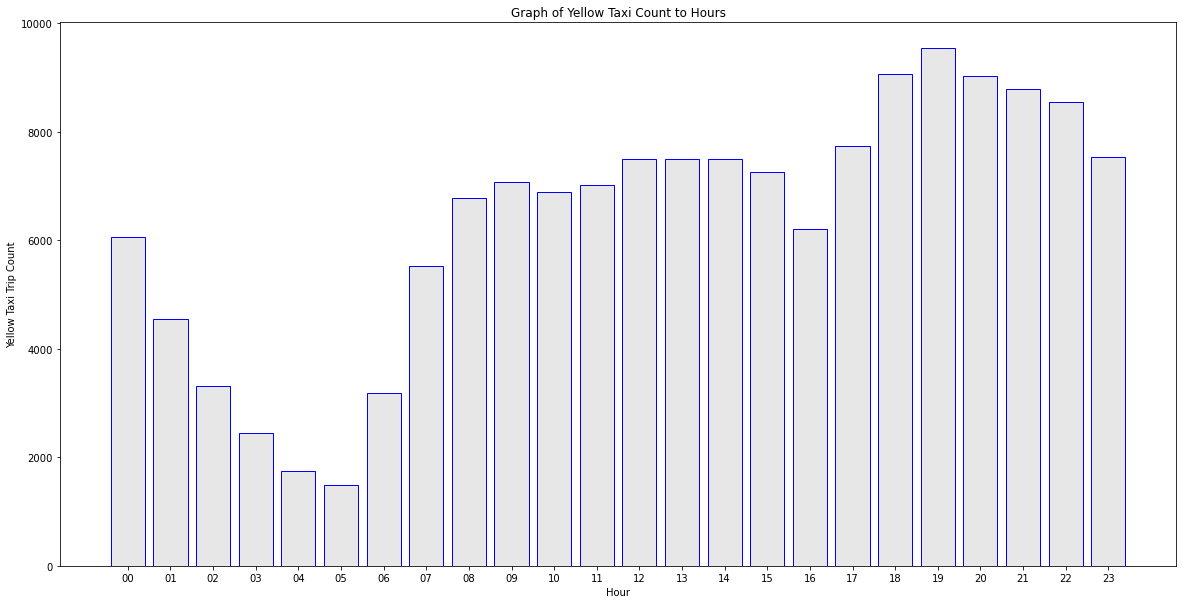

In [47]:
dataframe1 = pd.read_sql_query(text(QUERY_Q1),connection)

def plot_visual_1(dataframe):
    figure, axes = plt.subplots(figsize=(20, 10))
    plt.xlabel("Hour")
    plt.ylabel("Yellow Taxi Trip Count")
    axes.set_title("Graph of Yellow Taxi Count to Hours")
    plt.bar(dataframe["Hour_Taxi"], dataframe["COUNT(strftime ('%H',pickup_datetime))"], color=(0.1, 0.1, 0.1, 0.1),  edgecolor='blue');
    plt.show()

plot_visual_1(dataframe1)

### Q2 Visualization

In [48]:
QUERY_PART4_Q2='''
SELECT 
MONTH,
AVG(Distance) AS MEAN,
(SUM(Distance * Distance) - SUM(Distance) * AVG(Distance)) / COUNT(Distance) AS VAR,
COUNT(DIstance) AS COUNT
FROM (
    SELECT strftime('%m',datetime(substr(pickup_datetime, 1, 19))) AS MONTH, Distance
    FROM uber_trips
    WHERE Distance != 'None'
    AND Distance != 0
    UNION ALL
    SELECT strftime('%m',datetime(substr(pickup_datetime, 1, 19))) AS MONTH, Distance
    FROM taxi_trips
    WHERE Distance != 'None'
    AND Distance != 0
    )
    GROUP BY MONTH
'''
dataframe2 = pd.read_sql_query(text(QUERY_PART4_Q2),connection)


2022-12-10 15:26:19,600 INFO sqlalchemy.engine.Engine 
SELECT 
MONTH,
AVG(Distance) AS MEAN,
(SUM(Distance * Distance) - SUM(Distance) * AVG(Distance)) / COUNT(Distance) AS VAR,
COUNT(DIstance) AS COUNT
FROM (
    SELECT strftime('%m',datetime(substr(pickup_datetime, 1, 19))) AS MONTH, Distance
    FROM uber_trips
    WHERE Distance != 'None'
    AND Distance != 0
    UNION ALL
    SELECT strftime('%m',datetime(substr(pickup_datetime, 1, 19))) AS MONTH, Distance
    FROM taxi_trips
    WHERE Distance != 'None'
    AND Distance != 0
    )
    GROUP BY MONTH

2022-12-10 15:26:19,600 INFO sqlalchemy.engine.Engine [generated in 0.00085s] ()


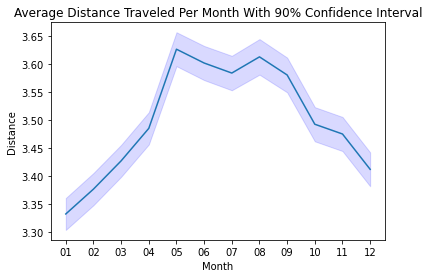

In [49]:

def plot_visual_2(dataframe):
    dataframe["upper"] = dataframe["MEAN"]+1.65 * dataframe["VAR"].apply(math.sqrt)/(dataframe["COUNT"].apply(math.sqrt))
    dataframe["lower"]=dataframe["MEAN"]-1.65 * dataframe["VAR"].apply(math.sqrt)/(dataframe["COUNT"].apply(math.sqrt))

    fig, ax = plt.subplots()
    x = dataframe['MONTH']
    ax.plot(x, dataframe['MEAN'])
    ax.fill_between(x, dataframe['lower'], dataframe['upper'], color='b', alpha=.15)
    plt.xlabel("Month")
    plt.ylabel("Distance")
    plt.title("Average Distance Traveled Per Month With 90% Confidence Interval")
plot_visual_2(dataframe2)


### Q3 Visualization

In [50]:
LGA_longitude = [-73.889454, -73.854876]
LGA_latitude = [40.766786, 40.781864]
JFK_longitude = [-73.824864, -73.747825]
JFK_latitude = [40.626869, 40.666786]
EWR_longitude = [-74.192964, -74.152685]
EWR_latitude = [40.670620, 40.708764]

QUERY_PART4_Q3_LGA ='''
SELECT strftime ('%w',substr(pickup_datetime, 1, 19)) AS WeekDay,
COUNT(Distance)
FROM (
    SELECT pickup_datetime, dropoff_longitude, dropoff_latitude, Distance
    FROM uber_trips
    WHERE dropoff_longitude >= -73.889454
    AND dropoff_longitude <= -73.854876
    AND dropoff_latitude >= 40.766786
    AND dropoff_latitude <= 40.781864
    AND Distance != 'None'
    UNION ALL
    SELECT pickup_datetime, dropoff_longitude, dropoff_latitude, Distance
    FROM taxi_trips
    WHERE dropoff_longitude >= -73.889454
    AND dropoff_longitude <= -73.854876
    AND dropoff_latitude >= 40.766786
    AND dropoff_latitude <= 40.781864
    AND Distance != 'None'
    )
GROUP BY WeekDay
'''

QUERY_PART4_Q3_JFK ='''
SELECT strftime ('%w',substr(pickup_datetime, 1, 19)) AS WeekDay,
COUNT(Distance)
FROM (
    SELECT pickup_datetime, dropoff_longitude, dropoff_latitude, Distance
    FROM uber_trips
    WHERE dropoff_longitude >= -73.824864
    AND dropoff_longitude <= -73.747825
    AND dropoff_latitude >= 40.626869
    AND dropoff_latitude <= 40.666786
    AND Distance != 'None'
    UNION ALL
    SELECT pickup_datetime, dropoff_longitude, dropoff_latitude, Distance
    FROM taxi_trips
    WHERE dropoff_longitude >= -73.824864
    AND dropoff_longitude <= -73.747825
    AND dropoff_latitude >= 40.626869
    AND dropoff_latitude <= 40.666786
    AND Distance != 'None'
    )
GROUP BY WeekDay
'''
QUERY_PART4_Q3_EWR ='''
SELECT strftime ('%w',substr(pickup_datetime, 1, 19)) AS WeekDay,
COUNT(Distance)
FROM (
    SELECT pickup_datetime, dropoff_longitude, dropoff_latitude, Distance
    FROM uber_trips
    WHERE dropoff_longitude >= -74.192964
    AND dropoff_longitude <= -74.152685
    AND dropoff_latitude >= 40.670620
    AND dropoff_latitude <= 40.708764
    AND Distance != 'None'
    UNION ALL
    SELECT pickup_datetime, dropoff_longitude, dropoff_latitude, Distance
    FROM taxi_trips
    WHERE dropoff_longitude >= -74.192964
    AND dropoff_longitude <= -74.152685
    AND dropoff_latitude >= 40.670620
    AND dropoff_latitude <= 40.708764
    AND Distance != 'None'
    )
GROUP BY WeekDay
'''

dataframe3_LGA = pd.read_sql_query(text(QUERY_PART4_Q3_LGA),connection)
dataframe3_JFK = pd.read_sql_query(text(QUERY_PART4_Q3_JFK),connection)
dataframe3_EWR = pd.read_sql_query(text(QUERY_PART4_Q3_EWR),connection)
dataframe3_0 = pd.merge(dataframe3_LGA,dataframe3_JFK,how = "left", on ="WeekDay")
dataframe3 = pd.merge(dataframe3_0,dataframe3_EWR,how = "left", on ="WeekDay")
dataframe3.columns = ["WeekDay", "LGA", "JFK", "EWR"]

2022-12-10 15:26:20,613 INFO sqlalchemy.engine.Engine 
SELECT strftime ('%w',substr(pickup_datetime, 1, 19)) AS WeekDay,
COUNT(Distance)
FROM (
    SELECT pickup_datetime, dropoff_longitude, dropoff_latitude, Distance
    FROM uber_trips
    WHERE dropoff_longitude >= -73.889454
    AND dropoff_longitude <= -73.854876
    AND dropoff_latitude >= 40.766786
    AND dropoff_latitude <= 40.781864
    AND Distance != 'None'
    UNION ALL
    SELECT pickup_datetime, dropoff_longitude, dropoff_latitude, Distance
    FROM taxi_trips
    WHERE dropoff_longitude >= -73.889454
    AND dropoff_longitude <= -73.854876
    AND dropoff_latitude >= 40.766786
    AND dropoff_latitude <= 40.781864
    AND Distance != 'None'
    )
GROUP BY WeekDay

2022-12-10 15:26:20,613 INFO sqlalchemy.engine.Engine [generated in 0.00068s] ()
2022-12-10 15:26:20,691 INFO sqlalchemy.engine.Engine 
SELECT strftime ('%w',substr(pickup_datetime, 1, 19)) AS WeekDay,
COUNT(Distance)
FROM (
    SELECT pickup_datetime, dropoff

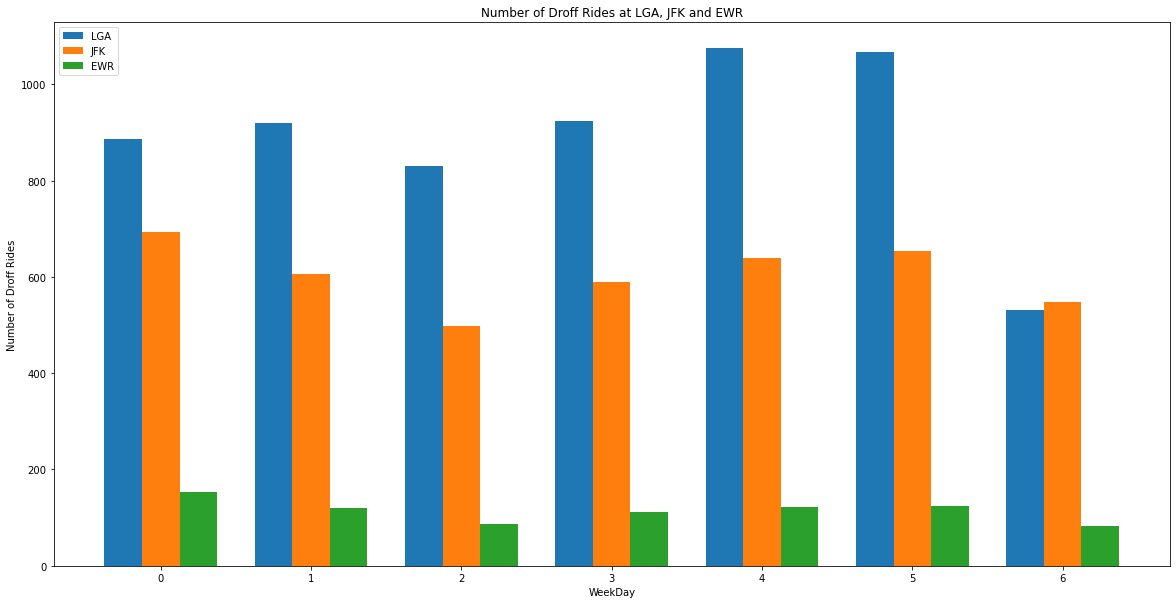

In [51]:

def plot_visual_3(dataframe):
    figure, axes = plt.subplots(figsize=(20, 10))

    WeekDay = list(dataframe["WeekDay"])
    LGA = list(dataframe["LGA"])
    JFK = list(dataframe["JFK"])
    EWR = list(dataframe["EWR"])
    bar_width = 0.25

    # Calculate the positions of the left sides of the bars
    LGA_pos = [i for i in range(len(WeekDay))]
    JFK_pos = [x + bar_width for x in LGA_pos]
    EWR_pos = [x + bar_width for x in JFK_pos]

    # Create the bars
    plt.bar(LGA_pos, LGA, width=bar_width, label="LGA")
    plt.bar(JFK_pos, JFK, width=bar_width, label="JFK")
    plt.bar(EWR_pos, EWR, width=bar_width, label="EWR")
    
    # Add labels and title
    plt.xlabel("WeekDay")
    plt.ylabel("Number of Droff Rides")
    plt.title("Number of Droff Rides at LGA, JFK and EWR")

    plt.xticks([p + bar_width for p in range(len(WeekDay))], WeekDay)
    plt.legend(loc="upper left")
    plt.show()

plot_visual_3(dataframe3)


### Q4 Visualization

In [52]:
QUERY_PART4_Q4='''
SELECT pickup_longitude,
pickup_latitude,
dropoff_longitude,
dropoff_latitude
FROM (
    SELECT pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude
    FROM uber_trips
    WHERE Distance != 'None'
    AND Distance != 0
    UNION ALL
    SELECT pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude
    FROM taxi_trips
    WHERE Distance != 'None'
    AND Distance != 0
    )
    LIMIT 10000
    '''
dataframe4 = pd.read_sql_query(text(QUERY_PART4_Q4),connection)


2022-12-10 15:26:21,199 INFO sqlalchemy.engine.Engine 
SELECT pickup_longitude,
pickup_latitude,
dropoff_longitude,
dropoff_latitude
FROM (
    SELECT pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude
    FROM uber_trips
    WHERE Distance != 'None'
    AND Distance != 0
    UNION ALL
    SELECT pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude
    FROM taxi_trips
    WHERE Distance != 'None'
    AND Distance != 0
    )
    LIMIT 10000
    
2022-12-10 15:26:21,200 INFO sqlalchemy.engine.Engine [generated in 0.00082s] ()


In [53]:
dataframe4 = pd.read_sql_query(text(QUERY_PART4_Q4),connection)
def plot_visual_4(dataframe):
    m = folium.Map([40.7128,  -74.0060], zoom_start=11)
    for index, row in dataframe4.iterrows():
        folium.CircleMarker([row['pickup_latitude'], row['pickup_longitude']],
                             radius=15,
                             fill_color="#3db7e4", # divvy color
                            ).add_to(m)
    hired_trip_pick= dataframe4[['pickup_latitude', 'pickup_longitude']].values
    m.add_child(plugins.HeatMap(hired_trip_pick, radius=15))
    for index, row in dataframe4.iterrows():
        folium.CircleMarker([row['dropoff_latitude'], row['dropoff_longitude']],
                             radius=15,
                             fill_color="#3db7e4", # divvy color
                            ).add_to(m)
    hired_trip_drop= dataframe4[['dropoff_latitude', 'dropoff_longitude']].values
    m.add_child(plugins.HeatMap(hired_trip_drop, radius=15))
    
    result = m.save("SreenShot_PART_Q4_Visualization.html")
    return result
    
plot_visual_4(dataframe4)  
#This HTML is too large to show in the github. Thus, we save as html in github. 
# In order to view this image, it's better to see it on "https://nbviewer.org/".


2022-12-10 15:26:21,254 INFO sqlalchemy.engine.Engine 
SELECT pickup_longitude,
pickup_latitude,
dropoff_longitude,
dropoff_latitude
FROM (
    SELECT pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude
    FROM uber_trips
    WHERE Distance != 'None'
    AND Distance != 0
    UNION ALL
    SELECT pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude
    FROM taxi_trips
    WHERE Distance != 'None'
    AND Distance != 0
    )
    LIMIT 10000
    
2022-12-10 15:26:21,255 INFO sqlalchemy.engine.Engine [cached since 0.05548s ago] ()


### Q5 Visualization

2022-12-10 15:26:28,103 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("taxi_trips")
2022-12-10 15:26:28,104 INFO sqlalchemy.engine.Engine [raw sql] ()
2022-12-10 15:26:28,106 INFO sqlalchemy.engine.Engine SELECT name FROM sqlite_master WHERE type='table' AND name NOT LIKE 'sqlite~_%' ESCAPE '~' ORDER BY name
2022-12-10 15:26:28,106 INFO sqlalchemy.engine.Engine [raw sql] ()
2022-12-10 15:26:28,107 INFO sqlalchemy.engine.Engine SELECT name FROM sqlite_temp_master WHERE type='table' AND name NOT LIKE 'sqlite~_%' ESCAPE '~' ORDER BY name
2022-12-10 15:26:28,107 INFO sqlalchemy.engine.Engine [raw sql] ()
2022-12-10 15:26:28,108 INFO sqlalchemy.engine.Engine PRAGMA main.table_xinfo("taxi_trips")
2022-12-10 15:26:28,108 INFO sqlalchemy.engine.Engine [raw sql] ()
2022-12-10 15:26:28,109 INFO sqlalchemy.engine.Engine SELECT sql FROM  (SELECT * FROM sqlite_master UNION ALL   SELECT * FROM sqlite_temp_master) WHERE name = ? AND type in ('table', 'view')
2022-12-10 15:26:28,110 INFO sqlalc

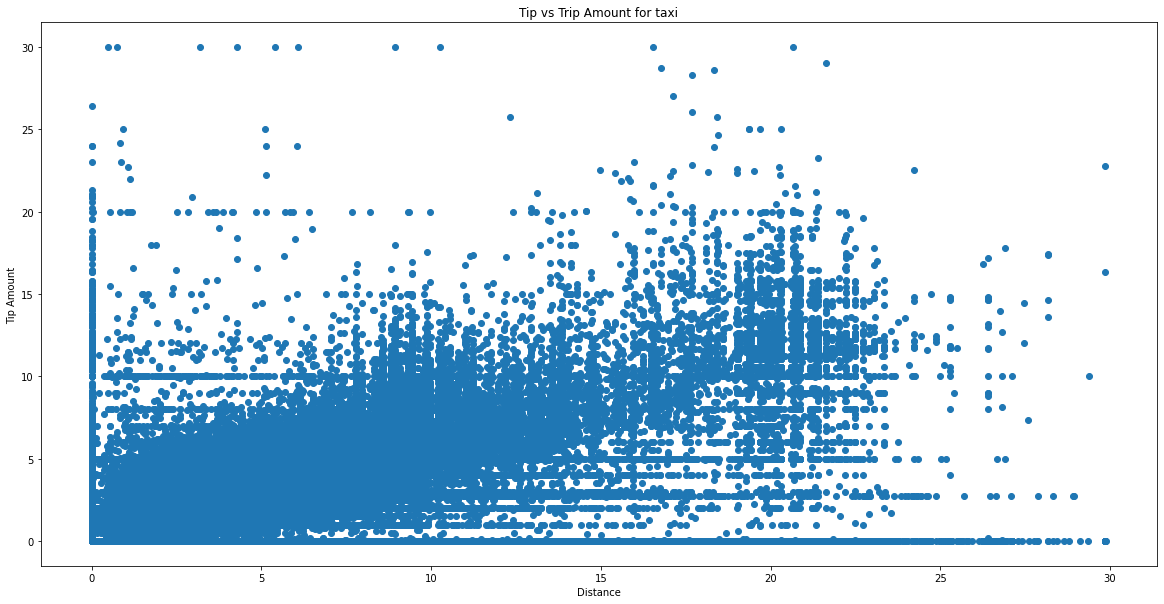

In [54]:
dataframe5=pd.read_sql("taxi_trips",connection)
dataframe5 = dataframe5.loc[dataframe5['Distance'] <= 30]
dataframe5 = dataframe5.loc[dataframe5['tip_amount'] <= 30 ]
dataframe5 = dataframe5.loc[dataframe5['tip_amount'] >= 0 ]
def plot_visual_n(dataframe):
    figure, axes = plt.subplots(figsize=(20, 10))
    

    x=dataframe["Distance"]
    y=dataframe["tip_amount"]
    axes.set_title("Tip vs Trip Amount for taxi")
    plt.xlabel("Distance")
    plt.ylabel("Tip Amount")
    plt.scatter(x, y)
    plt.show()

plot_visual_n(dataframe5)

### Q6 Visualization

2022-12-10 15:26:30,300 INFO sqlalchemy.engine.Engine 
SELECT 
strftime('%Y-%m-%d-%H',datetime(substr(pickup_datetime, 1, 19))) AS HOUR,
tip_amount
FROM taxi_trips
WHERE Distance != 'None'
AND Distance != 0
AND Distance < 30
AND tip_amount < 30
AND tip_amount != 0

2022-12-10 15:26:30,302 INFO sqlalchemy.engine.Engine [generated in 0.00234s] ()
2022-12-10 15:26:31,053 INFO sqlalchemy.engine.Engine 
SELECT 
strftime('%Y-%m-%d-%H',datetime(substr(DATE, 1, 19))) AS HOUR,
HourlyPrecipitation
FROM hourly_weather
WHERE HourlyPrecipitation !='None'

2022-12-10 15:26:31,054 INFO sqlalchemy.engine.Engine [generated in 0.00068s] ()


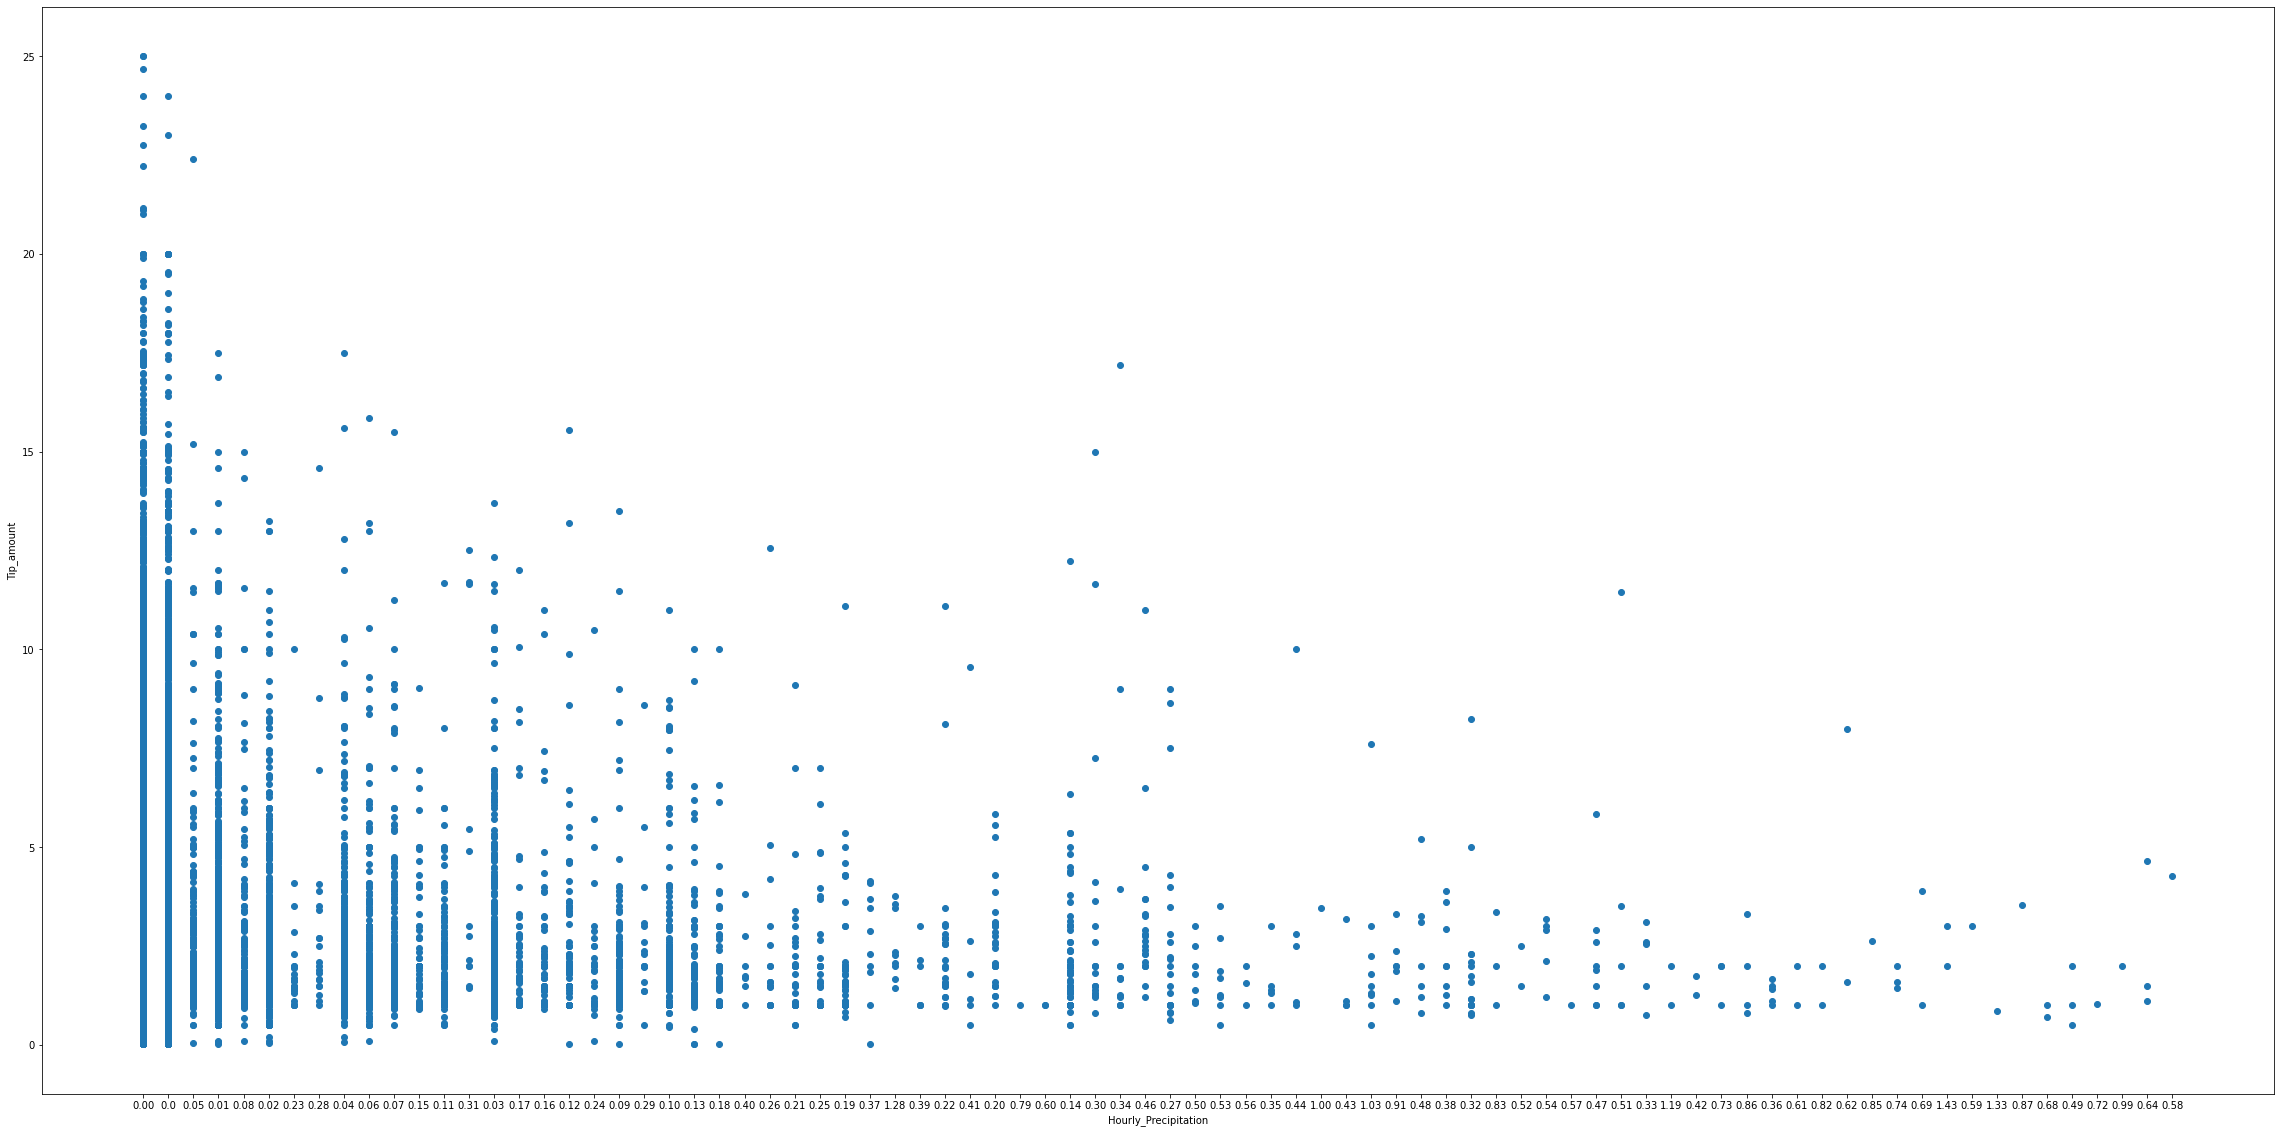

In [55]:
QUERY_PART4_Q6_taxi='''
SELECT 
strftime('%Y-%m-%d-%H',datetime(substr(pickup_datetime, 1, 19))) AS HOUR,
tip_amount
FROM taxi_trips
WHERE Distance != 'None'
AND Distance != 0
AND Distance < 30
AND tip_amount < 30
AND tip_amount != 0
'''

QUERY_PART4_Q6_weather='''
SELECT 
strftime('%Y-%m-%d-%H',datetime(substr(DATE, 1, 19))) AS HOUR,
HourlyPrecipitation
FROM hourly_weather
WHERE HourlyPrecipitation !='None'
'''

dataframe6_taxi = pd.read_sql_query(text(QUERY_PART4_Q6_taxi),connection)
dataframe6_weather = pd.read_sql_query(text(QUERY_PART4_Q6_weather),connection)
dataframe6 = pd.merge(dataframe6_taxi, dataframe6_weather, how = "left", on ="HOUR")
dataframe6 = dataframe6.dropna(axis=0,how='any')

def plot_visual_6():
    figure, axes = plt.subplots(figsize=(40, 20))
    plt.scatter(dataframe6["HourlyPrecipitation"], dataframe6["tip_amount"])
    plt.xlabel("Hourly_Precipitation")
    plt.ylabel("Tip_amount")
    plt.show()
plot_visual_6()

### Q7-Sunrise and Sunset Visualization

2022-12-10 15:26:33,055 INFO sqlalchemy.engine.Engine 
SELECT strftime('%m',datetime(substr(DATE, 1, 19))) AS MONTH,
Sunrise,
Sunset
FROM daily_sunrisesunset
GROUP BY MONTH

2022-12-10 15:26:33,056 INFO sqlalchemy.engine.Engine [cached since 14s ago] ()


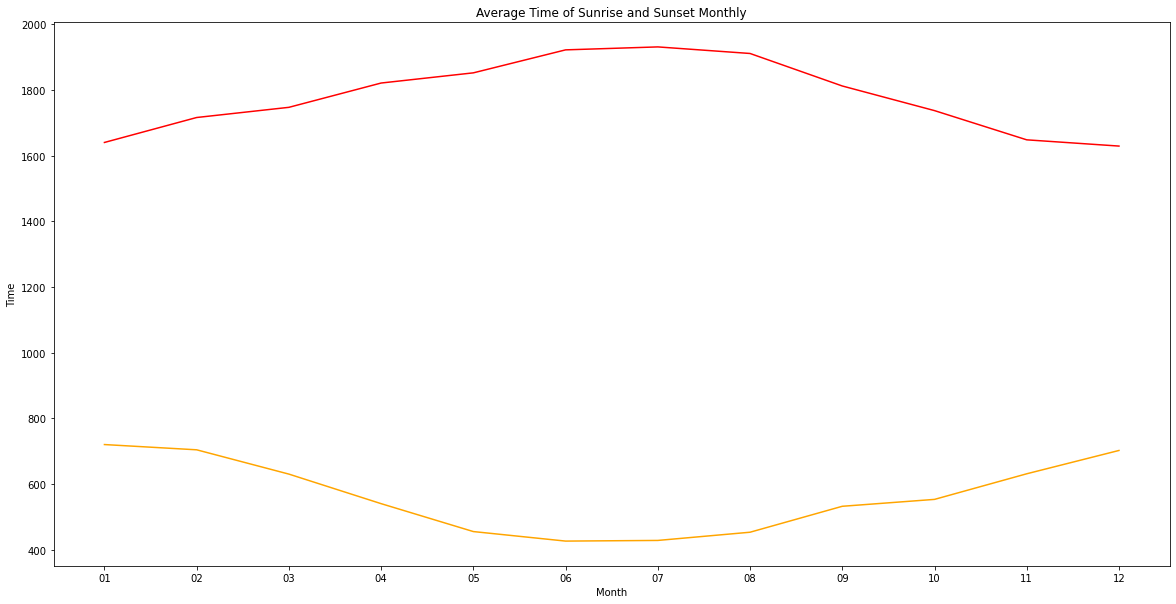

In [56]:
dataframe7 = pd.read_sql_query(text(QUERY_Q7),connection)

def plot_visual_7(dataframe):
    figure, axes = plt.subplots(figsize=(20, 10))
    plt.xlabel("Month")
    plt.ylabel("Time")
    axes.set_title("Average Time of Sunrise and Sunset Monthly")
    plt.plot(dataframe["MONTH"], dataframe["Sunrise"], label="Sunrise", color ='orange')
    plt.plot(dataframe["MONTH"], dataframe["Sunset"], label="Sunset", color ='red')
    plt.show()

plot_visual_7(dataframe7)
